<a href="https://colab.research.google.com/github/dnguyend/par-trans/blob/main/examples/NumpyStiefelParallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook to test Stiefel parallel transport using numpy

This should be run under CPU run time


In [1]:
!pip install git+https://github.com/dnguyend/par-trans

  Cloning https://github.com/dnguyend/par-trans to /tmp/pip-req-build-0_tl2__0
  Running command git clone --filter=blob:none --quiet https://github.com/dnguyend/par-trans /tmp/pip-req-build-0_tl2__0
  Resolved https://github.com/dnguyend/par-trans to commit f3dbb620f16aea1455b19b6b3599397edeecb39e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for par-trans: filename=par_trans-0.1.dev16+gf3dbb62-py3-none-any.whl size=32089 sha256=be53b806f70577b759e7d24600da748116475aa1d81beeff763499d6e2de6dbc
  Stored in directory: /tmp/pip-ephem-wheel-cache-hk_y0puz/wheels/43/54/27/33e127e64ed29c538e4b5356c5a5801c527ecfa659afe8ec3c
Successfully built par-trans


May take a bit to download - after that you will see "Collecting git+..."

Import the libraries

In [2]:
from time import perf_counter

import numpy as np
import numpy.linalg as la
from numpy.random import randn
import pandas as pd
from scipy.linalg import expm
import scipy.sparse.linalg as ssl

from par_trans.manifolds import Stiefel
from par_trans.utils.utils import (sym, asym, cz, vcat)
import par_trans.utils.expm_multiply_np as enp


Run several tests:
* check the metric compatible condition of the Levi-Civita connection. For 2 tangent vectors $v, va$, $X: z\mapsto stf.proj(z, va)$ is a vector field. We compare $D_v\langle X, X\rangle$ and $2\langle X, D_vX + \Gamma(v, X)\rangle$
* Check Geodesic and transport equations.
* The function stf.exp gives the Riemannian exponential map, while $stf.dexp(x, v, t,ddexp=True) $ computes $\gamma(t), \dot{\gamma}(t)$ and $\ddot{\gamma}(t)$ where $\gamma(t)$ is the geodesic starting at $x$ with initial velocity $\dot{\gamma}(0) = v$. If $ddexp=False$, only $\gamma$ and $\dot{\gamma}$ are returned.

We verify dexp indeed returns the time derivatives, and show the parallel transport equation is satisfied. We also show parallel transport with the customized solve_w (stf.paralle) is much faster than parallel transport using scipy expm_multiply, although numerically they are the same.


In [ ]:
def test_big():
    n = 300
    d = 200
    alp = .6
    stf = Stiefel(n, d, alp)

    x = stf.rand_point()
    v = stf.rand_vec(x)
    va = stf.rand_vec(x)
    # c = stf.rand_vec(np.eye(n)[:, :d])

    dlt = 1e-6
    t = .8
    print("CHECK METRIC COMPATIBILITY USING NUMERICAL DERIVATIVE")
    print((stf.inner(x+dlt*v, stf.proj(x+dlt*v, va), stf.proj(x+dlt*v, va)) - stf.inner(x, va, va))/dlt)
    print(2*stf.inner(x, va, (stf.proj(x+dlt*v, va) -va)/dlt + stf.christoffel_gamma(x, v, va)))

    r1 = (stf.proj(x+dlt*v, va) - stf.proj(x, va))/dlt + stf.christoffel_gamma(x, v, va)
    print("Check Christoffel gamma produces a connection")
    print(cz(sym(x.T@r1)))

    r1 = stf.exp(x, t*v)

    print("Check time derivatives of geodesics")
    print(np.allclose((stf.exp(x, (t+dlt)*v) - stf.exp(x, t*v))/dlt,
                      stf.dexp(x, v, t, ddexp=False)[1], atol=1e-3
                      ))

    print(np.allclose((stf.dexp(x, v, t+dlt)[1] - stf.dexp(x, v, t)[1])/dlt,
                      stf.dexp(x, v, t, ddexp=True)[2], atol=1e-2
                      ))

    gmms = stf.dexp(x, v, t, ddexp=True)

    print("CHECK Geodesic Equation with analytic differentiation")
    print(cz(gmms[2] + stf.christoffel_gamma(gmms[0], gmms[1], gmms[1])))

    t0 = perf_counter()
    Delta1 = stf.parallel_expm_multiply(x, v, va, t)
    t1 = perf_counter()
    Delta = stf.parallel(x, v, va, t)

    t2 = perf_counter()
    print(cz(Delta-Delta1))
    print("time expm_multiply =%f(s), time solv_w = %f(s)" % (t1 - t0, t2-t1))
    print("CHECK TRANSPORT EQUATION with numerical differentiation")
    print(cz((stf.parallel(x, v, va, t+dlt) - Delta)/dlt \
          + stf.christoffel_gamma(gmms[0], gmms[1], Delta)))
test_big()

CHECK METRIC COMPATIBILITY USING NUMERICAL DERIVATIVE
-652.0716087834444
-653.1156862036277
Check Christoffel gamma produces a connection
0.0002731664382673582
Check time derivatives of geodesics
True
True
CHECK Geodesic Equation with analytic differentiation
3.232969447708456e-13
3.3931191190106347e-14
time expm_multiply =8.085960(s), time solv_w = 1.136945(s)
CHECK TRANSPORT EQUATION with numerical differentiation
0.0002890385342873003


A quick check on the speed of parallel.

In [ ]:
def check_time():
  n = 300
  d = 200
  alp = .6
  stf = Stiefel(n, d, alp)
  x = stf.rand_point()
  v = stf.rand_vec(x)
  v = v/np.sqrt(stf.inner(x, v, v))
  va = stf.rand_vec(x)
  for t in [.5, 1., 2., 10., 20.]:
    t0 = perf_counter()
    stf.parallel(x, v, va, t)
    t1 = perf_counter()
    print("t=%f time=%f(s)" % (t, t1-t0))
check_time()

t=0.500000 time=0.182963(s)
t=1.000000 time=0.265760(s)
t=2.000000 time=0.265550(s)
t=10.000000 time=0.450326(s)
t=20.000000 time=0.359111(s)


In [ ]:
def check_time_d():
  n = 1000
  t = 1.
  for d in [10, 20, 50, 100, 200, 500]:
    alp = .6
    stf = Stiefel(n, d, alp)
    x = stf.rand_point()
    v = stf.rand_vec(x)
    v = v/np.sqrt(stf.inner(x, v, v))
    va = stf.rand_vec(x)
    t0 = perf_counter()
    stf.parallel(x, v, va, t)
    t1 = perf_counter()
    print("d=%d time=%f(s)" % (d, t1-t0))
check_time_d()

d=10 time=0.027288(s)
d=20 time=0.034854(s)
d=50 time=0.060433(s)
d=100 time=0.083501(s)
d=200 time=0.263608(s)
d=500 time=1.664051(s)


# TEST ISOMETRY

We show the inner product metric is preserved to around $10^{-14}$ accuracy up to $t=15$. THis will take a while to run. THe graph in the paper comes from a different run, but is mostly compatible. We note that if we run in higher dimension, the free colab sessions shows occasional spikes in error. This is not a problem in a local session with a high memory machine.

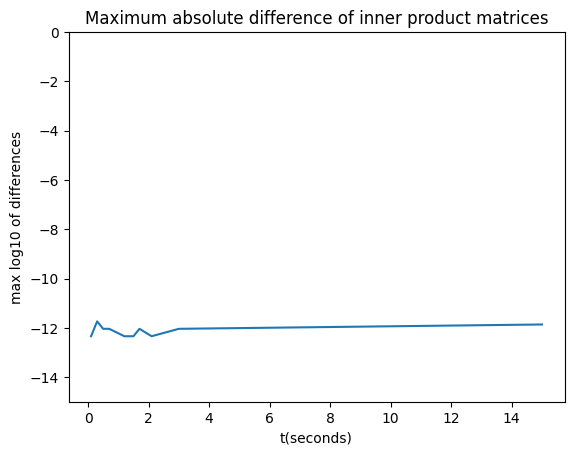

array([[  0.1       , -12.34222982],
       [  0.3       , -11.74016983],
       [  0.5       , -12.04119983],
       [  0.7       , -12.04119983],
       [  1.2       , -12.34222982],
       [  1.5       , -12.34222982],
       [  1.7       , -12.04119983],
       [  2.1       , -12.34222982],
       [  3.        , -12.04119983],
       [ 15.        , -11.86510857]])

In [ ]:
import matplotlib.pyplot as plt
import numpy.linalg as la

np.random.seed(0)
n = 2000
d = 100
alp = 1.
stf = Stiefel(n, d, alp)
x = np.concatenate([np.eye(d), np.zeros((n-d, d))])

n_samples = 20

all_smpl = []

def normalize(a, x):
    return a / np.sqrt(stf.inner(x, a, a))

for _ in range(n_samples):
    spl = stf.rand_vec(x)
    ft = np.random.choice(3*n_samples, (), replace=True)

    all_smpl.append(ft*normalize(spl, x))

all_smpl = np.array(all_smpl)


def cal_cov(gm, smpls):
    mat = np.zeros((n_samples,  n_samples))
    for i in range(n_samples):
        for j in range(i+1):
            mat[i, j] = stf.inner(gm, smpls[i, :, :], smpls[j, :, :])
            if i != j:
                mat[j, i] = mat[i, j]
    return mat

cov_0 = cal_cov(x, all_smpl)

v = stf.rand_vec(x)
v = v/np.sqrt(stf.inner(x, v, v))

cov_diff = []
# t_grid = [0.5, 1., 2., 5., 10., 15.]
# t_grid = [0.5, 1.]
t_grid = [0.1, .3, .5, .7, 1.2, 1.5, 1.7, 2.1, 3., 15.]
for t in t_grid:
    transported = []
    for i in range(n_samples):
        transported.append(stf.parallel(x, v, all_smpl[i, :, :], t))

    transported = np.array(transported)
    gm = stf.exp(x, t*v)
    cov_t = cal_cov(gm, transported)
    # print(cz(cov_t- cov_0))
    cov_diff.append((t, cov_t))

plt.plot(t_grid, [np.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])
plt.ylim(-15, 0)
plt.xlabel("t(seconds)")
plt.ylabel("max log10 of differences")
plt.title("Maximum absolute difference of inner product matrices")
plt.savefig("cov_diff_stief.png")
plt.show()
display(np.concatenate([np.array(t_grid)[:, None], np.array([np.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])[:, None]], axis=1))

# Check effect of changing n, d, and t
This takes the most time. This may run faster on a machine with better hardware than on a free colab session.

In [ ]:
def test_one_set(stf, t_interval, n_samples=10, n_repeats=5):
    ret = []
    d = stf.shape[1]
    for _ in range(n_samples):
        ret_spl = []
        x = stf.rand_point()
        v = stf.rand_vec(x)
        va = stf.rand_vec(x)
        # compile the git
        stf.dexp(x, v, 1.)
        par = stf.parallel(x, v, va, 1.)
        dlt = 1e-7
        for t in t_interval:
            ret_t = []
            for _ in range(n_repeats):
                t0 = perf_counter()
                gmms = stf.dexp(x, v, t)
                t1 = perf_counter()
                t_gmms = t1 - t0

                t3 = perf_counter()
                par = stf.parallel(x, v, va, t)
                t4 = perf_counter()
                t_par = t4 - t3

                # check accuracy:
                geo_man = cz(gmms[0].T@gmms[0] - np.eye(d))
                par_tan = cz(sym(gmms[0].T@par))
                par_eq = cz((stf.parallel(x, v, va, t+dlt) - stf.parallel(x, v, va, t))/dlt +
                            stf.christoffel_gamma(gmms[0], gmms[1], par))

                ret_t.append([t_gmms, t_par, geo_man, par_tan, par_eq])


            ret_spl.append(ret_t)
        ret.append(ret_spl)

    return np.array(ret)


def test_time():
    t_interval = np.array([.5, 1., 2., 5., 20.])

    # first test, fixed d = 100
    d_list = np.array([50])
    n_list = np.array([100, 200, 1000, 2000])
    # n_list = np.array([100])

    alp_list = np.array([.5, 1.])

    all_ret_0 = {}
    for d in d_list:
        for n in n_list:
            print("Doing n=%d d=%d" % (n, d))
            if n <= d:
                continue
            for i_alp in range(alp_list.shape[0]):
                stf = Stiefel(n, d, alp_list[i_alp])
                ret = test_one_set(stf, t_interval, n_samples=5, n_repeats=2)
                all_ret_0[int(d), int(n), i_alp] = ret

    tbl = []
    for t_idx in range(t_interval.shape[0]):
        for idx, val in all_ret_0.items():
            tbl.append([idx[1], idx[2], t_interval[t_idx]] + list(val[:, t_idx, :, :].mean(axis=((0, 1)))))

    raw_tbl = []
    for idx, val in all_ret_0.items():
        for t_idx in range(t_interval.shape[0]):
            for i_s in range(val.shape[0]):
                for i_r in range(val.shape[2]):
                    raw_tbl.append([idx[1], idx[2], t_interval[t_idx]] + list(val[i_s, t_idx, i_r, :]))

    pd.DataFrame(raw_tbl).to_pickle('by_n.pkl')

    # second test, fix n = 2000, test d = [5, 10, 20, 200, 500]
    d_list = np.array([5, 10, 20, 100])
    # d_list = np.array([5])
    n_list = np.array([1000])

    alp_list = np.array([.5, 1.])

    all_ret_1 = {}
    for d in d_list:
        for n in n_list:
            print("Doing n=%d d=%d" % (n, d))
            if n <= d:
                continue
            for i_alp in range(alp_list.shape[0]):
                stf = Stiefel(n, d, alp_list[i_alp])
                ret = test_one_set(stf, t_interval, n_samples=5, n_repeats=2)
                all_ret_1[int(d), int(n), i_alp] = ret

    tbl1 = []
    for t_idx in range(t_interval.shape[0]):
        for idx, val in all_ret_1.items():
            tbl1.append([idx[0], idx[2], t_interval[t_idx]] + list(val[:, t_idx, :, :].mean(axis=((0, 1)))))

    raw_tbl1 = []
    for idx, val in all_ret_1.items():
        for t_idx in range(t_interval.shape[0]):
            for i_s in range(val.shape[0]):
                for i_r in range(val.shape[2]):
                    raw_tbl1.append([idx[0], idx[2], t_interval[t_idx]] + list(val[i_s, t_idx, i_r, :]))

    pd.DataFrame(raw_tbl1).to_pickle('by_d_1000.pkl')
test_time()

Doing n=100 d=50
Doing n=200 d=50
Doing n=1000 d=50
Doing n=2000 d=50
Doing n=1000 d=5
Doing n=1000 d=10
Doing n=1000 d=20
Doing n=1000 d=100


In [ ]:
def display_test():
    by_n_tbl = pd.read_pickle('by_n.pkl')
    # by_n_tbl.iloc[:, 2:] = np.array(by_n_tbl.iloc[:, 2:])
    by_n_tbl.iloc[:, 2] = [f"{a:04.1f}" for a in by_n_tbl.iloc[:, 2].values]
    by_n_tbl.columns = ['n', 'alp', 't', 'geo_time', 'par_time', 'err_geo', 'err_tan', 'err_eq']
    by_n_tbl['log_err_eq'] = [np.log10(a) for a in by_n_tbl.err_eq.values]

    by_n_prep = by_n_tbl.pivot_table(index=['alp', 'n'],
                                     columns='t',
                                     values=['par_time', 'log_err_eq'],
                                     aggfunc='mean')
    def str1(a):
        return '%.1f' % a

    def str2(a):
        return '%.2f' % a

    print(by_n_prep.to_latex(formatters=5*[str1] + 5*[str2]))
    # alp_tbl = jnp.array([.5, 1.])
    # by_n_tbl.loc[:, 'alp'] = alp_tbl[by_n_tbl.loc[:, 'alp'].values]
    print("BY n")
    display(by_n_prep)
    if False:
      by_d_tbl = pd.read_pickle('by_d_1000.pkl')
      by_d_tbl.iloc[:, 2] = [f"{a:04.1f}" for a in by_d_tbl.iloc[:, 2].values]
      by_d_tbl.columns = ['d', 'alp', 't', 'geo_time', 'par_time', 'err_geo', 'err_tan', 'err_eq']

      by_d_tbl['log_err_eq'] = [jnp.log10(a) for a in by_d_tbl.err_eq.values]

      by_d_prep = by_d_tbl.pivot_table(index=['alp', 'd'],
                                      columns='t',
                                      values=['par_time', 'log_err_eq'],
                                      aggfunc='mean')

      print(by_d_prep.to_latex(formatters=5*[str1] + 5*[str2]))

    by_d_tbl = pd.read_pickle('by_d_1000.pkl')
    by_d_tbl.iloc[:, 2] = [f"{a:04.1f}" for a in by_d_tbl.iloc[:, 2].values]
    by_d_tbl.columns = ['d', 'alp', 't', 'geo_time', 'par_time', 'err_geo', 'err_tan', 'err_eq']

    by_d_tbl['log_err_eq'] = [np.log10(a) for a in by_d_tbl.err_eq.values]

    by_d_prep = by_d_tbl.pivot_table(index=['alp', 'd'],
                                     columns='t',
                                     values=['par_time', 'log_err_eq'],
                                     aggfunc='mean')
    display("-------------------------------------------------------------------------")
    display("BY d")
    display(by_d_prep)
    print(by_d_prep.to_latex(formatters=5*[str1] + 5*[str2]))

display_test()

\begin{tabular}{llrrrrrrrrrr}
\toprule
 &  & \multicolumn{5}{r}{log_err_eq} & \multicolumn{5}{r}{par_time} \\
 & t & 00.5 & 01.0 & 02.0 & 05.0 & 20.0 & 00.5 & 01.0 & 02.0 & 05.0 & 20.0 \\
alp & n &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0} & 100 & -5.0 & -5.0 & -5.0 & -5.0 & -5.0 & 0.04 & 0.08 & 0.14 & 0.25 & 0.59 \\
 & 200 & -4.8 & -4.8 & -4.8 & -4.8 & -4.8 & 0.07 & 0.13 & 0.16 & 0.25 & 0.75 \\
 & 1000 & -4.4 & -4.4 & -4.3 & -4.3 & -4.3 & 0.13 & 0.19 & 0.25 & 0.48 & 1.23 \\
 & 2000 & -4.2 & -4.2 & -4.2 & -4.2 & -4.2 & 0.23 & 0.28 & 0.35 & 0.61 & 1.80 \\
\cline{1-12}
\multirow[t]{4}{*}{1} & 100 & -5.0 & -5.0 & -5.0 & -5.0 & -5.0 & 0.08 & 0.12 & 0.17 & 0.32 & 1.13 \\
 & 200 & -4.8 & -4.8 & -4.8 & -4.8 & -4.8 & 0.09 & 0.14 & 0.20 & 0.37 & 1.44 \\
 & 1000 & -4.4 & -4.4 & -4.4 & -4.4 & -4.4 & 0.17 & 0.21 & 0.33 & 0.61 & 2.10 \\
 & 2000 & -4.2 & -4.2 & -4.3 & -4.2 & -4.3 & 0.26 & 0.32 & 0.46 & 0.76 & 2.73 \\
\cline{1-12}
\bottomrule
\end{tabular}

BY n


log_err_eq                                          par_time  \
t              00.5      01.0      02.0      05.0      20.0      00.5   
alp n                                                                   
0   100   -5.011105 -5.023583 -5.023144 -5.021880 -5.027441  0.043055   
    200   -4.757506 -4.786158 -4.776533 -4.812232 -4.795579  0.073524   
    1000  -4.357422 -4.357074 -4.335853 -4.349574 -4.317785  0.131467   
    2000  -4.183569 -4.168497 -4.177679 -4.192222 -4.184098  0.231849   
1   100   -4.979976 -4.989534 -5.002837 -5.001933 -5.004371  0.083915   
    200   -4.816202 -4.806861 -4.800008 -4.779349 -4.796083  0.090577   
    1000  -4.408088 -4.445975 -4.431318 -4.412268 -4.407993  0.166344   
    2000  -4.245843 -4.249934 -4.261488 -4.245742 -4.264588  0.258817   

                                                  
t             01.0      02.0      05.0      20.0  
alp n                                             
0   100   0.077471  0.135493  0.251304  0.594134  
    200   0.127507  0.163728  0.247761  0.749154  
    1000  0.191718  0.254261  0.477293  1.233095  
    2000  0.275165  0.348800  0.611977  1.802104  
1   100   0.123778  0.172790  0.319059  1.127511  
    200   0.143203  0.197729  0.366764  1.435307  
    1000  0.209868  0.329302  0.614268  2.098809  
    2000  0.319838  0.457374  0.763832  2.733797

'-------------------------------------------------------------------------'

'BY d'

log_err_eq                                          par_time  \
t             00.5      01.0      02.0      05.0      20.0      00.5   
alp d                                                                  
0   5    -4.883740 -4.869021 -4.912543 -4.866786 -4.824417  0.026334   
    10   -4.712564 -4.732298 -4.673344 -4.677695 -4.683509  0.033984   
    20   -4.551031 -4.556833 -4.541947 -4.526018 -4.529463  0.056693   
    100  -4.215331 -4.234423 -4.218272 -4.199079 -4.227448  0.347407   
1   5    -4.873023 -4.852055 -4.870456 -4.808043 -4.887007  0.036661   
    10   -4.792852 -4.795809 -4.747543 -4.761448 -4.772640  0.041460   
    20   -4.583259 -4.610476 -4.593388 -4.591063 -4.612682  0.074287   
    100  -4.263268 -4.259762 -4.258701 -4.275183 -4.285951  0.535483   

                                                  
t            01.0      02.0      05.0       20.0  
alp d                                             
0   5    0.038042  0.063085  0.130137   0.287105  
    10   0.054379  0.079949  0.148168   0.402485  
    20   0.079044  0.139746  0.191708   0.454072  
    100  0.588611  0.974655  2.150808   8.385455  
1   5    0.066377  0.106120  0.151517   0.399309  
    10   0.061878  0.090595  0.171208   0.614166  
    20   0.101847  0.158787  0.257087   0.664484  
    100  0.762802  1.538195  3.513833  14.067596

\begin{tabular}{llrrrrrrrrrr}
\toprule
 &  & \multicolumn{5}{r}{log_err_eq} & \multicolumn{5}{r}{par_time} \\
 & t & 00.5 & 01.0 & 02.0 & 05.0 & 20.0 & 00.5 & 01.0 & 02.0 & 05.0 & 20.0 \\
alp & d &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0} & 5 & -4.9 & -4.9 & -4.9 & -4.9 & -4.8 & 0.03 & 0.04 & 0.06 & 0.13 & 0.29 \\
 & 10 & -4.7 & -4.7 & -4.7 & -4.7 & -4.7 & 0.03 & 0.05 & 0.08 & 0.15 & 0.40 \\
 & 20 & -4.6 & -4.6 & -4.5 & -4.5 & -4.5 & 0.06 & 0.08 & 0.14 & 0.19 & 0.45 \\
 & 100 & -4.2 & -4.2 & -4.2 & -4.2 & -4.2 & 0.35 & 0.59 & 0.97 & 2.15 & 8.39 \\
\cline{1-12}
\multirow[t]{4}{*}{1} & 5 & -4.9 & -4.9 & -4.9 & -4.8 & -4.9 & 0.04 & 0.07 & 0.11 & 0.15 & 0.40 \\
 & 10 & -4.8 & -4.8 & -4.7 & -4.8 & -4.8 & 0.04 & 0.06 & 0.09 & 0.17 & 0.61 \\
 & 20 & -4.6 & -4.6 & -4.6 & -4.6 & -4.6 & 0.07 & 0.10 & 0.16 & 0.26 & 0.66 \\
 & 100 & -4.3 & -4.3 & -4.3 & -4.3 & -4.3 & 0.54 & 0.76 & 1.54 & 3.51 & 14.07 \\
\cline{1-12}
\bottomrule
\end{tabular}



A detail check to show the customize solver solve_w runs more than 10 times faster than the library call

In [ ]:
def sc(ar, ft):
    arn = ar.copy()
    arn[:ar.shape[1], :] *= ft
    return arn


def par(b, ar, alp):
    d = ar.shape[1]
    b_a = b[:d, :]
    b_r = b[d:, :]
    a = ar[:d, :]
    r = ar[d:, :]

    return vcat(
        (4*alp-1)*asym(b_a@a) + asym(r.T@b_r),
        alp*(b_r@a-r@b_a))


def par_T(b, ar, alp):
    d = ar.shape[1]
    b_a = b[:d, :]
    b_r = b[d:, :]
    a = ar[:d, :]
    r = ar[d:, :]

    return vcat(
        -(4*alp-1)*asym(b_a)@a - alp*r.T@b_r,
        r@asym(b_a) - alp*b_r@a)


def par_bal(b, ar, salp):
    d = ar.shape[1]
    b_a = b[:d, :]
    b_r = b[d:, :]
    a = ar[:d, :]
    r = ar[d:, :]

    return vcat(
        ((4*salp**2-1)*asym(b_a@a) + salp*asym(r.T@b_r)),
        (salp**2*b_r@a-salp*r@b_a))


def solve_w(b, ar, alp, t, tol=None):
    _theta = {
        # The first 30 values are from table A.3 of Computing Matrix Functions.
        1: 2.29e-16,
        2: 2.58e-8,
        3: 1.39e-5,
        4: 3.40e-4,
        5: 2.40e-3,
        6: 9.07e-3,
        7: 2.38e-2,
        8: 5.00e-2,
        9: 8.96e-2,
        10: 1.44e-1,
        # 11
        11: 2.14e-1,
        12: 3.00e-1,
        13: 4.00e-1,
        14: 5.14e-1,
        15: 6.41e-1,
        16: 7.81e-1,
        17: 9.31e-1,
        18: 1.09,
        19: 1.26,
        20: 1.44,
        # 21
        21: 1.62,
        22: 1.82,
        23: 2.01,
        24: 2.22,
        25: 2.43,
        26: 2.64,
        27: 2.86,
        28: 3.08,
        29: 3.31,
        30: 3.54,
        # The rest are from table 3.1 of
        # Computing the Action of the Matrix Exponential.
        35: 4.7,
        40: 6.0,
        45: 7.2,
        50: 8.5,
        55: 9.9,
    }

    salp = np.sqrt(alp)
    _, d = ar.shape

    def one_norm_est():
        na = t*salp*la.norm(
            np.concatenate([
                ar[d:, :],  np.abs(4*alp-1)/salp*la.norm(ar[:d, :],1)*np.ones((1, d))]), 1)

        nr = t*salp*(salp*la.norm(np.concatenate(
            [ar[:d, :], 1/salp*la.norm(ar[d:, :], np.inf)*np.ones((1, d))]),
                                  1))
        return max(na, nr)

    norm_est = one_norm_est()

    def calc_m_s(norm_est):
        best_m = None
        best_s = None
        for m, theta in _theta.items():
            s = int(np.ceil(norm_est / theta))
            if best_m is None or m * s < best_m * best_s:
                best_m = m
                best_s = s
        return best_m, best_s

    m_star, s = calc_m_s(norm_est)

    if tol is None:
        u_d = 2 ** -53
        tol = u_d
    f = b.copy()

    def norm2(x):
        return np.sqrt(np.sum(x*x))

    for _ in range(s):
        c1 = norm2(b)
        for j in range(m_star):
            b = t / float(s*(j+1)) * par_bal(b, ar, salp)
            c2 = norm2(b)
            f = f + b
            if c1 + c2 <= tol * norm2(f):
                break
            c1 = c2
        b = f
    return f


def test_stiefel_fast():
    n = 1000
    d = 500

    alp = .6
    stf = Stiefel(n, d, alp)
    x = np.concatenate([np.eye(d), np.zeros((n-d, d))])

    def normalize(x, ar):
        return ar/np.sqrt(stf.inner(x, ar, ar))

    ar = stf.rand_vec(x)
    b = stf.rand_vec(x)
    c = stf.rand_vec(x)

    ar = normalize(x, ar)
    b = normalize(x, b)
    c = normalize(x, c)

    salp = np.sqrt(alp)
    # par_bal
    print("CHECK PAR_BAL formula")
    print(cz(par_bal(b, ar, salp)
             - sc(par(sc(b, 1/salp), ar, alp), salp)))

    print(np.sum(par_bal(b, ar, salp)*c) +
          np.sum(par_bal(c, ar, salp)*b))

    t = 1.2
    # time different way to solve the ODE
    p_opt = ssl.LinearOperator(
        (n*d, n*d),
        matvec=lambda w: t*par(w.reshape(n, d), ar, alp).reshape(-1),
        rmatvec=lambda w: -t*par_T(w.reshape(n, d), ar, alp).reshape(-1))

    gmms = stf.exp(x, t*ar)

    t0 = perf_counter()
    val1 = ssl.expm_multiply(p_opt, b.reshape(-1), traceA=0).reshape(n, d)
    t1 = perf_counter()
    print("Time scipy expm_multiply %f" % (t1 - t0))

    t2 = perf_counter()
    val2 = enp.expm_multiply(p_opt, b.reshape(-1), traceA=0, use_frag_31=False).reshape(n, d)
    t3 = perf_counter()
    print("Time expm_multiply use only 1-norm %f" % (t3 - t2))

    t4 = perf_counter()
    val3 = sc(solve_w(sc(b, salp), ar, alp, t), 1/salp)
    t5 = perf_counter()
    print("Time using solve_w %f" % (t5 - t4))
    print("Time ratio between expm_multipy and solve_w %f" % ((t1-t0)/(t5-t4)))
    print("Compare values")
    print(cz(val1-val2))
    print(cz(val1-val3))
test_stiefel_fast()

CHECK PAR_BAL formula
2.439454888092385e-19
1.6940658945086007e-20
Time scipy expm_multiply 5.082546
Time expm_multiply use only 1-norm 5.523014
Time using solve_w 0.458826
Time ratio between expm_multipy and solve_w 11.077296
Compare values
0.0
2.6020852139652106e-18
